In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "arro3-core",
#     "geoarrow-rust-core",
#     "geoarrow-rust-io>=0.4.1",
#     "lonboard",
#     "numpy",
#     "obstore",
#     "shapely",
# ]
# ///

# Visualizing Spatially-Partitioned GeoParquet with Lonboard, Obstore & GeoArrow-Rust

[GeoParquet](https://geoparquet.org/) is a fast, cloud-native file format for geospatial vector data. There's a lot of excitement around _spatially-partitioned_ GeoParquet, where the data within one or more GeoParquet files is arranged spatially. This allows GeoParquet readers to select data from a spatial query without loading and parsing the entire dataset.

It can be useful to inspect and visualize the spatial partitioning of such GeoParquet datasets. In this notebook we'll visualize both the high-level spatial partitioning and specific spatial extracts in Lonboard. This uses [Obstore](https://developmentseed.org/obstore/latest/) to browse data on object storage, plus the [Python bindings to GeoArrow-Rust](https://geoarrow.org/geoarrow-rs/python/latest/) to actually load spatially the GeoParquet data into Python.

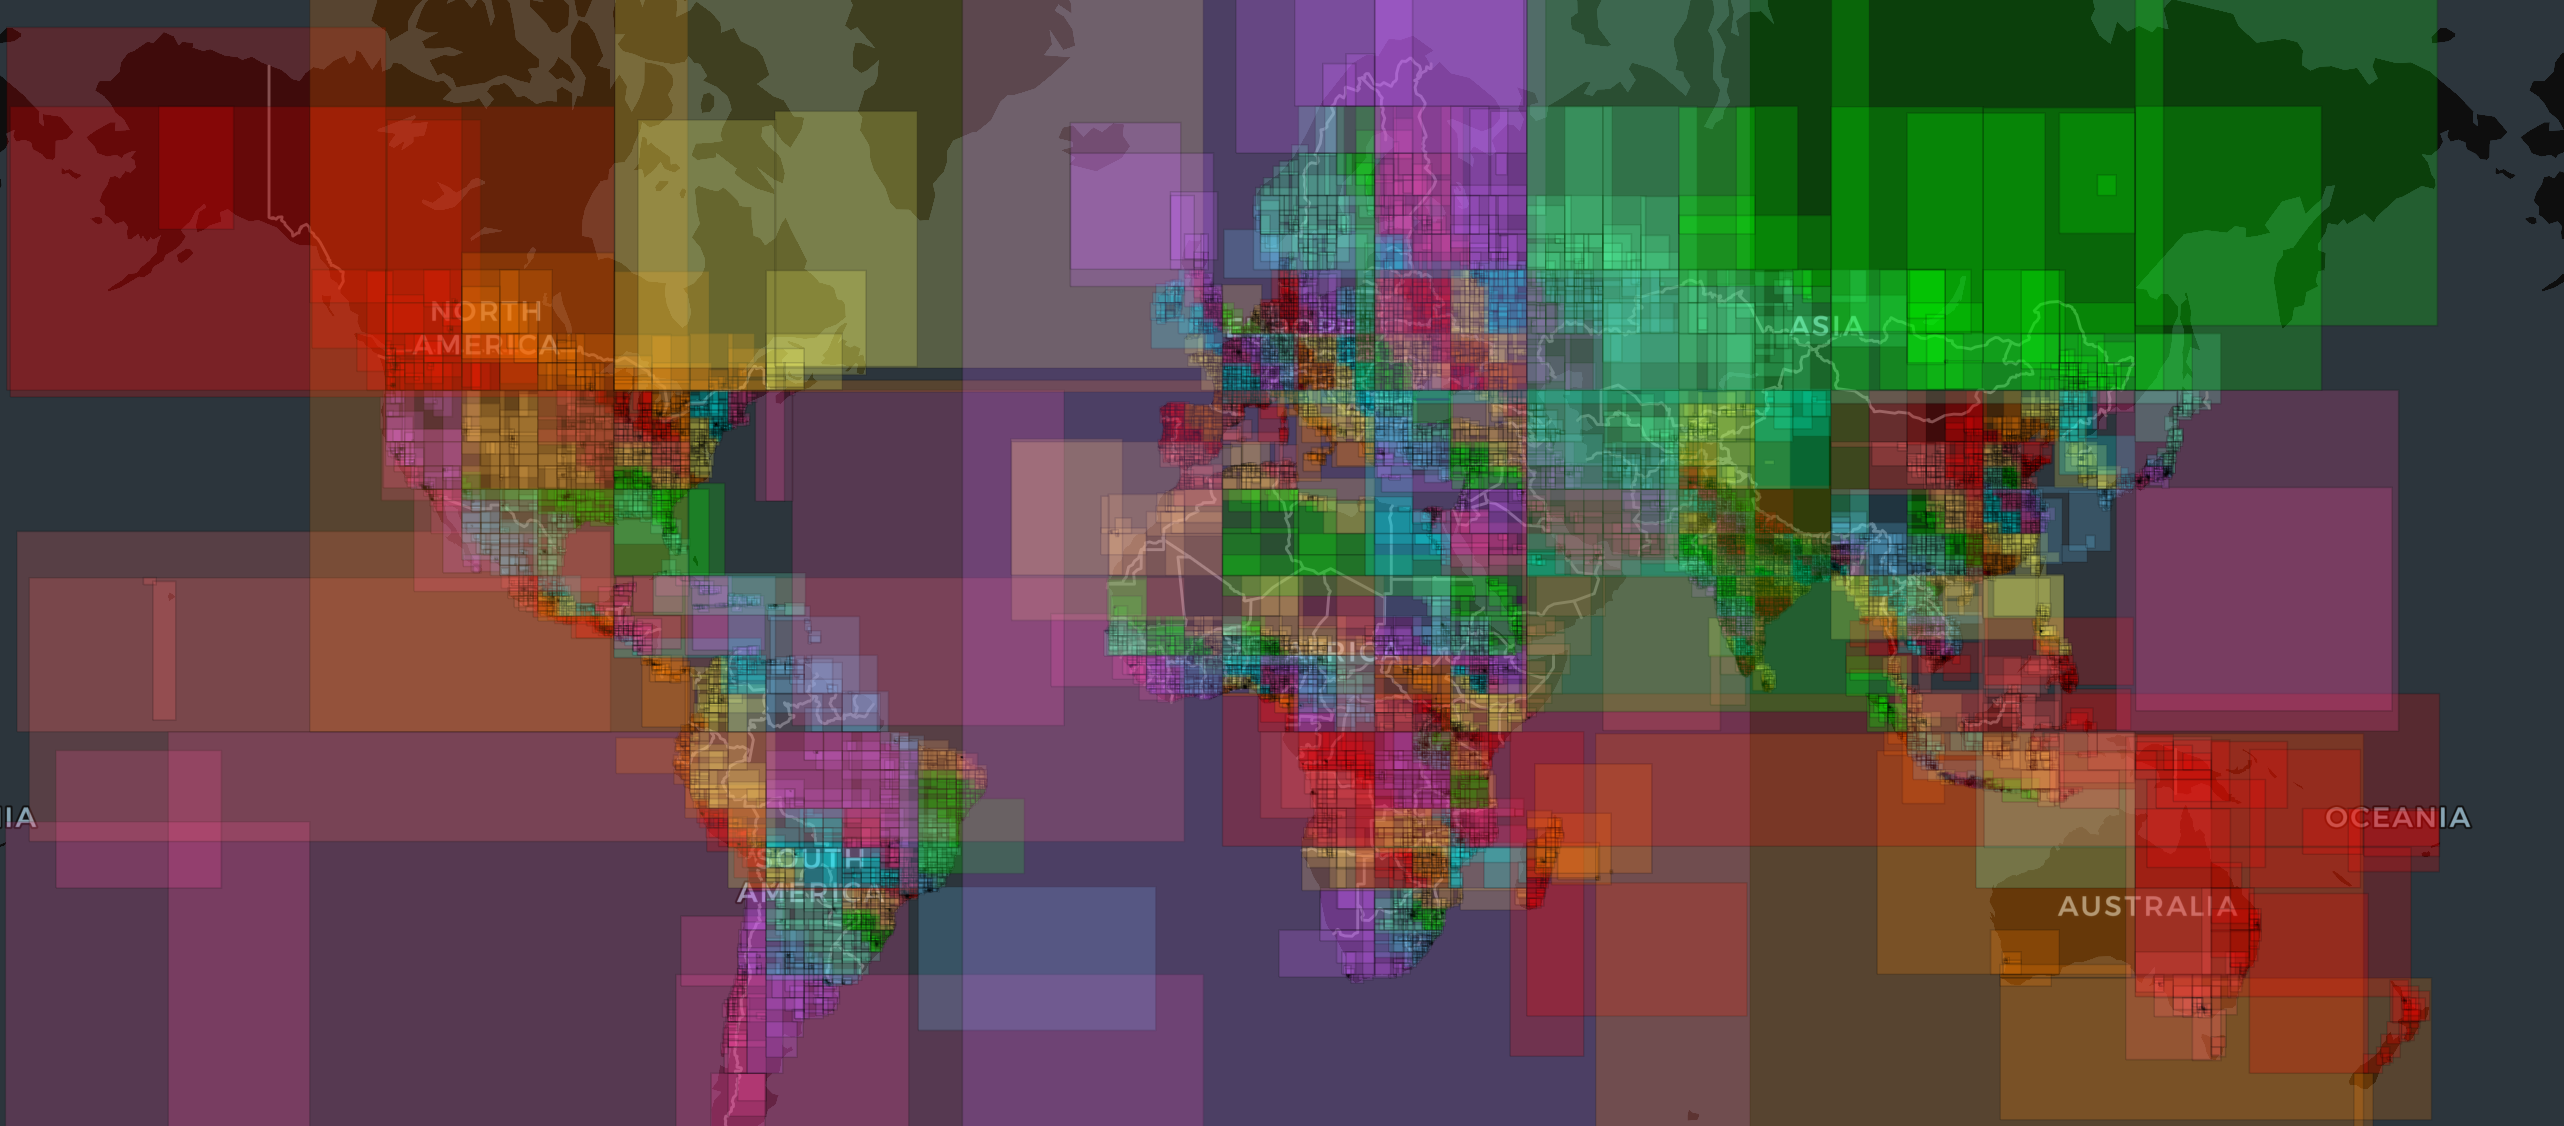


## Dependencies

First install [`uv`](https://docs.astral.sh/uv) and then run this notebook with

```
uvx juv run overture-geoparquet.ipynb
```

(The `uvx` command is included when installing `uv`). That will automatically create a temporary `uv` environment with the dependencies required by this notebook.


## Imports


In [ ]:
import numpy as np
import shapely
from arro3.core import Array, DataType, Table
from geoarrow.rust.io import GeoParquetDataset
from obstore.store import S3Store

from lonboard import Map, PolygonLayer, viz
from lonboard.basemap import CartoBasemap

## Accessing Overture data on Cloud Storage


We'll create an [S3Store](https://developmentseed.org/obstore/latest/api/store/aws/#obstore.store.S3Store) to access Overture data on AWS S3.


In [ ]:
store = S3Store.from_url(
    "s3://overturemaps-us-west-2/release/2025-06-25.0/",
    region="us-west-2",
    skip_signature=True,
)

Overture has [two official copies](https://docs.overturemaps.org/getting-data/#official-overture-sources) of their distribution: one on AWS and another on Azure Storage.

The nice part about Obstore is that we could alternatively create an [`AzureStore`](https://developmentseed.org/obstore/latest/api/store/azure/#obstore.store.AzureStore) to access the Azure-based copy, and **all the following steps would work the same**. If you'd like, uncomment the next cell to load the following data from Azure.


In [ ]:
# from obstore.store import AzureStore
#
# store = AzureStore.from_url(
#     "https://overturemapswestus2.blob.core.windows.net/release/2025-06-25.0",
#     skip_signature=True,
# )

Let's inspect the directories under this release. The [`list_with_delimiter`](https://developmentseed.org/obstore/latest/api/list/#obstore.list_with_delimiter) method shows us the `common_prefixes` (i.e. directories) underneath our top-level bucket prefix.


In [ ]:
store.list_with_delimiter()

Now let's say we want to visualize buildings; we can inspect the directories within `theme=buildings`:


In [ ]:
store.list_with_delimiter("theme=buildings")

And the directories within `theme=buildings/type=building`.

This gives us the object metadata for each of these raw Parquet files:


In [ ]:
objects = store.list_with_delimiter("theme=buildings/type=building")["objects"]
objects[:2]

## Creating a `GeoParquetDataset`


Now we can open a `GeoParquetDataset` with these objects:


In [ ]:
dataset = GeoParquetDataset.open(objects, store=store)

We can see how many _row groups_, or partitions, exist in the dataset:


In [ ]:
dataset.num_row_groups

And the total number of rows:


In [ ]:
dataset.num_rows

Calling `dataset.fragments` gives us access the raw underlying GeoParquet files:


In [ ]:
dataset.fragments[:5]

## Visualizing file-based Spatial Partitioning

GeoParquet has two _levels_ at which data can be partitioned: at the _file_ level and then additional within each file per _row group_.

First, we'll visualize the spatial distribution of each file by plotting the bounding boxes of each file. These boxes imply that all the data contained within the file is contained within one of these boxes.

Each `fragment` is a `GeoParquetFile` with a `file_bbox` method to access the bounding box information from the GeoParquet covering column.


In [ ]:
file_bounds = [shapely.box(*fragment.file_bbox()) for fragment in dataset.fragments]

In [ ]:
m = viz(file_bounds)
for layer in m.layers:
    layer.opacity = 0.05
    layer.auto_highlight = True
m

## Visualizing Row Group-based Spatial Partitioning


> **_Note_**: I'm not sure why but Lonboard has been less stable for me recently on Mac with large data. You may want to remove the above map before proceeding (right click on the cell containing the map, then choose "Clear Cell Output").

But within each file there's another set of spatial partitioning. Let's inspect this inner level as well.

Each fragment additionally has a `row_groups_bounds` method to access the bounding box information from the GeoParquet covering column.

We can loop over each file in the dataset, getting the bounding box of each row group in the file. Here we'll also create another column with the string file path that the row groups come from so that we can later associate them.


In [ ]:
row_groups_bounds = []
for fragment in dataset.fragments:
    bounds = fragment.row_groups_bounds()
    file_path = Array([fragment.path] * len(bounds), DataType.string())
    row_group_idx = np.arange(len(bounds))
    bounds_table = Table.from_arrays(
        [bounds, file_path, row_group_idx],
        names=["bounds", "file_path", "row_group_idx"],
    )
    row_groups_bounds.append(bounds_table)

So for example, the first GeoParquet file has these bounds for each GeoParquet row group:


In [ ]:
row_groups_bounds[0]["bounds"]

Now we'll create a Lonboard `PolygonLayer` for each of these chunks. We'll use the following color mapping to give the chunks from each file a different color.


In [ ]:
COLORS = [
    "#FC49A3",  # pink
    "#CC66FF",  # purple-ish
    "#66CCFF",  # sky blue
    "#66FFCC",  # teal
    "#00FF00",  # lime green
    "#FFCC66",  # light orange
    "#FF6666",  # salmon
    "#FF0000",  # red
    "#FF8000",  # orange
    "#FFFF66",  # yellow
    "#00FFFF",  # turquoise
]

In [ ]:
layers = []
for i, chunk in enumerate(row_groups_bounds):
    color = COLORS[i % len(COLORS)]
    layer = PolygonLayer(
        chunk,
        get_fill_color=color,
        get_line_color=[0, 0, 0, 200],
        opacity=0.03,
        line_width_min_pixels=0.8,
        auto_highlight=True,
    )
    layers.append(layer)

In [ ]:
m = Map(layers, _height=600, basemap_style=CartoBasemap.DarkMatter)

In [ ]:
m

## Fetching GeoParquet data


Now we'll fetch a spatial subset of data.

First, **use the button on the top right of the map** to create a (small) bounding box selection. Keep in mind that selecting too large of an area will make the data download take a long time.


In [ ]:
m.selected_bounds

In [ ]:
assert m.selected_bounds is not None, (
    "Use the map's bounding box selection to select a small download area"
)

Now we can use the `read` method on our `GeoParquetDataset` to actually fetch data.


In [ ]:
data = dataset.read(bbox=m.selected_bounds)

In [ ]:
data.num_rows

Now you should be able to plot the data directly!


In [ ]:
viz(data, map_kwargs={"_height": 600})